In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, Optional


In [2]:
def safe_average(val1, val2):
    """Calculate average handling missing values"""
    val1_clean = val1 if pd.notna(val1) else np.nan
    val2_clean = val2 if pd.notna(val2) else np.nan
    
    if pd.isna(val1_clean) and pd.isna(val2_clean):
        return np.nan
    elif pd.isna(val1_clean):
        return val2_clean
    elif pd.isna(val2_clean):
        return val1_clean
    else:
        return (val1_clean + val2_clean) / 2

def coalesce(val1, val2):
    """Return first non-null value"""
    return val1 if pd.notna(val1) else val2


In [3]:
def create_mid_term_hybrid_forecast(mid_reconciled_forecast: pd.DataFrame) -> pd.DataFrame:
    """Create mid-term hybrid forecast with TS source"""
    if len(mid_reconciled_forecast) == 0:
        return pd.DataFrame()
    
    mid_hybrid = mid_reconciled_forecast.copy()
    mid_hybrid = mid_hybrid.rename(columns={'TS_FORECAST_VALUE_REC': 'TS_FORECAST_VALUE'})
    
    mid_hybrid['HYBRID_FORECAST_VALUE'] = mid_hybrid['TS_FORECAST_VALUE']
    mid_hybrid['ENSEMBLE_FORECAST_VALUE'] = np.nan
    mid_hybrid['FORECAST_SOURCE'] = 'ts'
    
    required_cols = [
        'product_lvl_id', 'location_lvl_id', 'customer_lvl_id', 'distr_channel_lvl_id',
        'PERIOD_DT', 'PERIOD_END_DT', 'TS_FORECAST_VALUE', 'SEGMENT_NAME',
        'DEMAND_TYPE', 'ASSORTMENT_TYPE', 'ML_FORECAST_VALUE',
        'HYBRID_FORECAST_VALUE', 'ENSEMBLE_FORECAST_VALUE', 'FORECAST_SOURCE'
    ]
    
    for col in required_cols:
        if col not in mid_hybrid.columns:
            if col in ['SEGMENT_NAME', 'DEMAND_TYPE', 'ASSORTMENT_TYPE']:
                mid_hybrid[col] = np.nan
            elif col == 'ML_FORECAST_VALUE':
                mid_hybrid[col] = np.nan
            else:
                mid_hybrid[col] = 0
    
    return mid_hybrid[required_cols]


In [4]:
def join_ts_ml_forecasts(reconciled_forecast: pd.DataFrame, 
                        ib_zero_demand_threshold: float = 0.01) -> pd.DataFrame:
    """Join TS and ML forecasts with business rules"""
    if len(reconciled_forecast) == 0:
        return pd.DataFrame()
    
    result_df = reconciled_forecast.copy()
    
    result_df['TS_FORECAST_VALUE_F'] = result_df.apply(
        lambda row: coalesce(row.get('TS_FORECAST_VALUE_REC'), row.get('ML_FORECAST_VALUE')), 
        axis=1
    )
    result_df['ML_FORECAST_VALUE_F'] = result_df.apply(
        lambda row: coalesce(row.get('ML_FORECAST_VALUE'), row.get('TS_FORECAST_VALUE_REC')), 
        axis=1
    )
    
    def apply_business_rules(row):
        ts_val = row['TS_FORECAST_VALUE_F']
        ml_val = row['ML_FORECAST_VALUE_F']
        demand_type = str(row.get('DEMAND_TYPE', '')).lower()
        segment_name = str(row.get('SEGMENT_NAME', '')).lower()
        assortment_type = str(row.get('ASSORTMENT_TYPE', '')).lower()
        
        ml_priority = (
            (demand_type == 'promo' and segment_name != 'retired') or
            segment_name == 'short' or
            assortment_type == 'new'
        )
        
        ts_priority = (
            segment_name == 'retired' or
            segment_name == 'low volume' or
            (pd.notna(ts_val) and ts_val <= ib_zero_demand_threshold)
        )
        
        if ml_priority:
            hybrid_value = ml_val
            forecast_source = 'ml'
            ensemble_value = np.nan
        elif ts_priority:
            hybrid_value = ts_val
            forecast_source = 'ts'
            ensemble_value = np.nan
        else:
            hybrid_value = safe_average(ts_val, ml_val)
            forecast_source = 'ensemble'
            ensemble_value = safe_average(ts_val, ml_val)
        
        return pd.Series({
            'HYBRID_FORECAST_VALUE': hybrid_value,
            'FORECAST_SOURCE': forecast_source,
            'ENSEMBLE_FORECAST_VALUE': ensemble_value
        })
    
    business_rules_result = result_df.apply(apply_business_rules, axis=1)
    result_df = pd.concat([result_df, business_rules_result], axis=1)
    result_df = result_df.rename(columns={'TS_FORECAST_VALUE_REC': 'TS_FORECAST_VALUE'})
    result_df = result_df.drop(columns=['TS_FORECAST_VALUE_F', 'ML_FORECAST_VALUE_F'], errors='ignore')
    
    return result_df


In [5]:
def hybrid_forecast_generation_pipeline(reconciled_forecast: pd.DataFrame,
                                       mid_reconciled_forecast: pd.DataFrame = None,
                                       ib_zero_demand_threshold: float = 0.01) -> pd.DataFrame:
    """Complete hybrid forecast generation pipeline"""
    
    mid_term_hybrid = pd.DataFrame()
    if mid_reconciled_forecast is not None and len(mid_reconciled_forecast) > 0:
        mid_term_hybrid = create_mid_term_hybrid_forecast(mid_reconciled_forecast)
    
    short_term_hybrid = join_ts_ml_forecasts(reconciled_forecast, ib_zero_demand_threshold)
    
    if len(mid_term_hybrid) > 0:
        for col in short_term_hybrid.columns:
            if col not in mid_term_hybrid.columns:
                mid_term_hybrid[col] = np.nan
        
        for col in mid_term_hybrid.columns:
            if col not in short_term_hybrid.columns:
                short_term_hybrid[col] = np.nan
        
        column_order = short_term_hybrid.columns.tolist()
        mid_term_hybrid = mid_term_hybrid[column_order]
        
        hybrid_forecast = pd.concat([short_term_hybrid, mid_term_hybrid], 
                                  ignore_index=True, sort=False)
    else:
        hybrid_forecast = short_term_hybrid
    
    required_output_cols = [
        'product_lvl_id', 'location_lvl_id', 'customer_lvl_id', 'distr_channel_lvl_id',
        'PERIOD_DT', 'PERIOD_END_DT', 'TS_FORECAST_VALUE', 'SEGMENT_NAME',
        'DEMAND_TYPE', 'ASSORTMENT_TYPE', 'ML_FORECAST_VALUE',
        'HYBRID_FORECAST_VALUE', 'ENSEMBLE_FORECAST_VALUE', 'FORECAST_SOURCE'
    ]
    
    for col in required_output_cols:
        if col not in hybrid_forecast.columns:
            hybrid_forecast[col] = np.nan
    
    return hybrid_forecast[required_output_cols]


In [6]:
# Data Generation
np.random.seed(42)

IB_ZERO_DEMAND_THRESHOLD = 0.01

start_date = datetime(2024, 7, 16)
end_date = start_date + timedelta(days=45)
dates = pd.date_range(start_date, end_date, freq='D')

products = [101, 102, 103, 104, 105]
locations = [1, 2, 3]
customers = [1, 2]  
distr_channels = [1]


In [7]:
reconciled_data = []

segments_config = {
    'Premium': {'retired_prob': 0.1, 'low_volume_prob': 0.1, 'short_prob': 0.05},
    'Standard': {'retired_prob': 0.05, 'low_volume_prob': 0.2, 'short_prob': 0.1}, 
    'Economy': {'retired_prob': 0.15, 'low_volume_prob': 0.3, 'short_prob': 0.15},
    'Luxury': {'retired_prob': 0.05, 'low_volume_prob': 0.05, 'short_prob': 0.1},
    'Retired': {'retired_prob': 1.0, 'low_volume_prob': 0.0, 'short_prob': 0.0},
    'Low Volume': {'retired_prob': 0.0, 'low_volume_prob': 1.0, 'short_prob': 0.0},
    'Short': {'retired_prob': 0.0, 'low_volume_prob': 0.0, 'short_prob': 1.0}
}

demand_types = ['regular', 'promo']
assortment_types = ['old', 'new']

for product in products:
    for location in locations:
        for customer in customers:
            for distr_channel in distr_channels:
                segment_name = np.random.choice(list(segments_config.keys()))
                
                short_dates = dates[:30]
                for date in short_dates:
                    ts_base = np.random.uniform(50, 200)
                    ml_base = np.random.uniform(60, 180)
                    
                    ts_val = ts_base if np.random.random() > 0.05 else np.nan
                    ml_val = ml_base if np.random.random() > 0.1 else np.nan
                    
                    if np.random.random() < 0.05:
                        ts_val = np.random.uniform(0, IB_ZERO_DEMAND_THRESHOLD * 0.5)
                    
                    demand_type = np.random.choice(demand_types, p=[0.7, 0.3])
                    assortment_type = np.random.choice(assortment_types, p=[0.8, 0.2])
                    
                    reconciled_data.append({
                        'product_lvl_id': product,
                        'location_lvl_id': location,
                        'customer_lvl_id': customer,
                        'distr_channel_lvl_id': distr_channel,
                        'PERIOD_DT': date,
                        'PERIOD_END_DT': date,
                        'TS_FORECAST_VALUE_REC': ts_val,
                        'SEGMENT_NAME': segment_name,
                        'DEMAND_TYPE': demand_type,
                        'ASSORTMENT_TYPE': assortment_type,
                        'ML_FORECAST_VALUE': ml_val
                    })

reconciled_forecast = pd.DataFrame(reconciled_data)
reconciled_forecast.head()


,product_lvl_id,location_lvl_id,customer_lvl_id,distr_channel_lvl_id,PERIOD_DT,PERIOD_END_DT,TS_FORECAST_VALUE_REC,SEGMENT_NAME,DEMAND_TYPE,ASSORTMENT_TYPE,ML_FORECAST_VALUE
0,101,1,1,1,2024-07-16,2024-07-16,169.481448,Short,regular,old,82.012175
1,101,1,1,1,2024-07-17,2024-07-17,100.056292,Short,promo,old,NaN
2,101,1,1,1,2024-07-18,2024-07-18,0.002624,Short,regular,old,NaN
3,101,1,1,1,2024-07-19,2024-07-19,196.063328,Short,promo,old,87.932561
4,101,1,1,1,2024-07-20,2024-07-20,178.991061,Short,regular,old,NaN


In [8]:
mid_reconciled_data = []

mid_dates = dates[30:]
for product in products:
    for location in locations:
        for customer in customers:
            for distr_channel in distr_channels:
                segment_name = np.random.choice(['Premium', 'Standard', 'Economy'])
                
                for date in mid_dates:
                    ts_val = np.random.uniform(40, 150)
                    
                    mid_reconciled_data.append({
                        'product_lvl_id': product,
                        'location_lvl_id': location,
                        'customer_lvl_id': customer,
                        'distr_channel_lvl_id': distr_channel,
                        'PERIOD_DT': date,
                        'PERIOD_END_DT': date,
                        'TS_FORECAST_VALUE_REC': ts_val,
                        'SEGMENT_NAME': segment_name,
                        'DEMAND_TYPE': 'regular',
                        'ASSORTMENT_TYPE': 'old',
                        'ML_FORECAST_VALUE': np.nan
                    })

mid_reconciled_forecast = pd.DataFrame(mid_reconciled_data)


In [9]:
# Results
hybrid_forecast = hybrid_forecast_generation_pipeline(
    reconciled_forecast=reconciled_forecast,
    mid_reconciled_forecast=mid_reconciled_forecast,
    ib_zero_demand_threshold=IB_ZERO_DEMAND_THRESHOLD
)

print(f"Generated {len(hybrid_forecast)} hybrid forecast records")
hybrid_forecast.head()


Generated 1380 hybrid forecast records


,product_lvl_id,location_lvl_id,customer_lvl_id,distr_channel_lvl_id,PERIOD_DT,PERIOD_END_DT,TS_FORECAST_VALUE,SEGMENT_NAME,DEMAND_TYPE,ASSORTMENT_TYPE,ML_FORECAST_VALUE,HYBRID_FORECAST_VALUE,ENSEMBLE_FORECAST_VALUE,FORECAST_SOURCE
0,101,1,1,1,2024-07-16,2024-07-16,169.481448,Short,regular,old,82.012175,82.012175,NaN,ml
1,101,1,1,1,2024-07-17,2024-07-17,100.056292,Short,promo,old,NaN,100.056292,NaN,ml
2,101,1,1,1,2024-07-18,2024-07-18,0.002624,Short,regular,old,NaN,0.002624,NaN,ml
3,101,1,1,1,2024-07-19,2024-07-19,196.063328,Short,promo,old,87.932561,87.932561,NaN,ml
4,101,1,1,1,2024-07-20,2024-07-20,178.991061,Short,regular,old,NaN,178.991061,NaN,ml


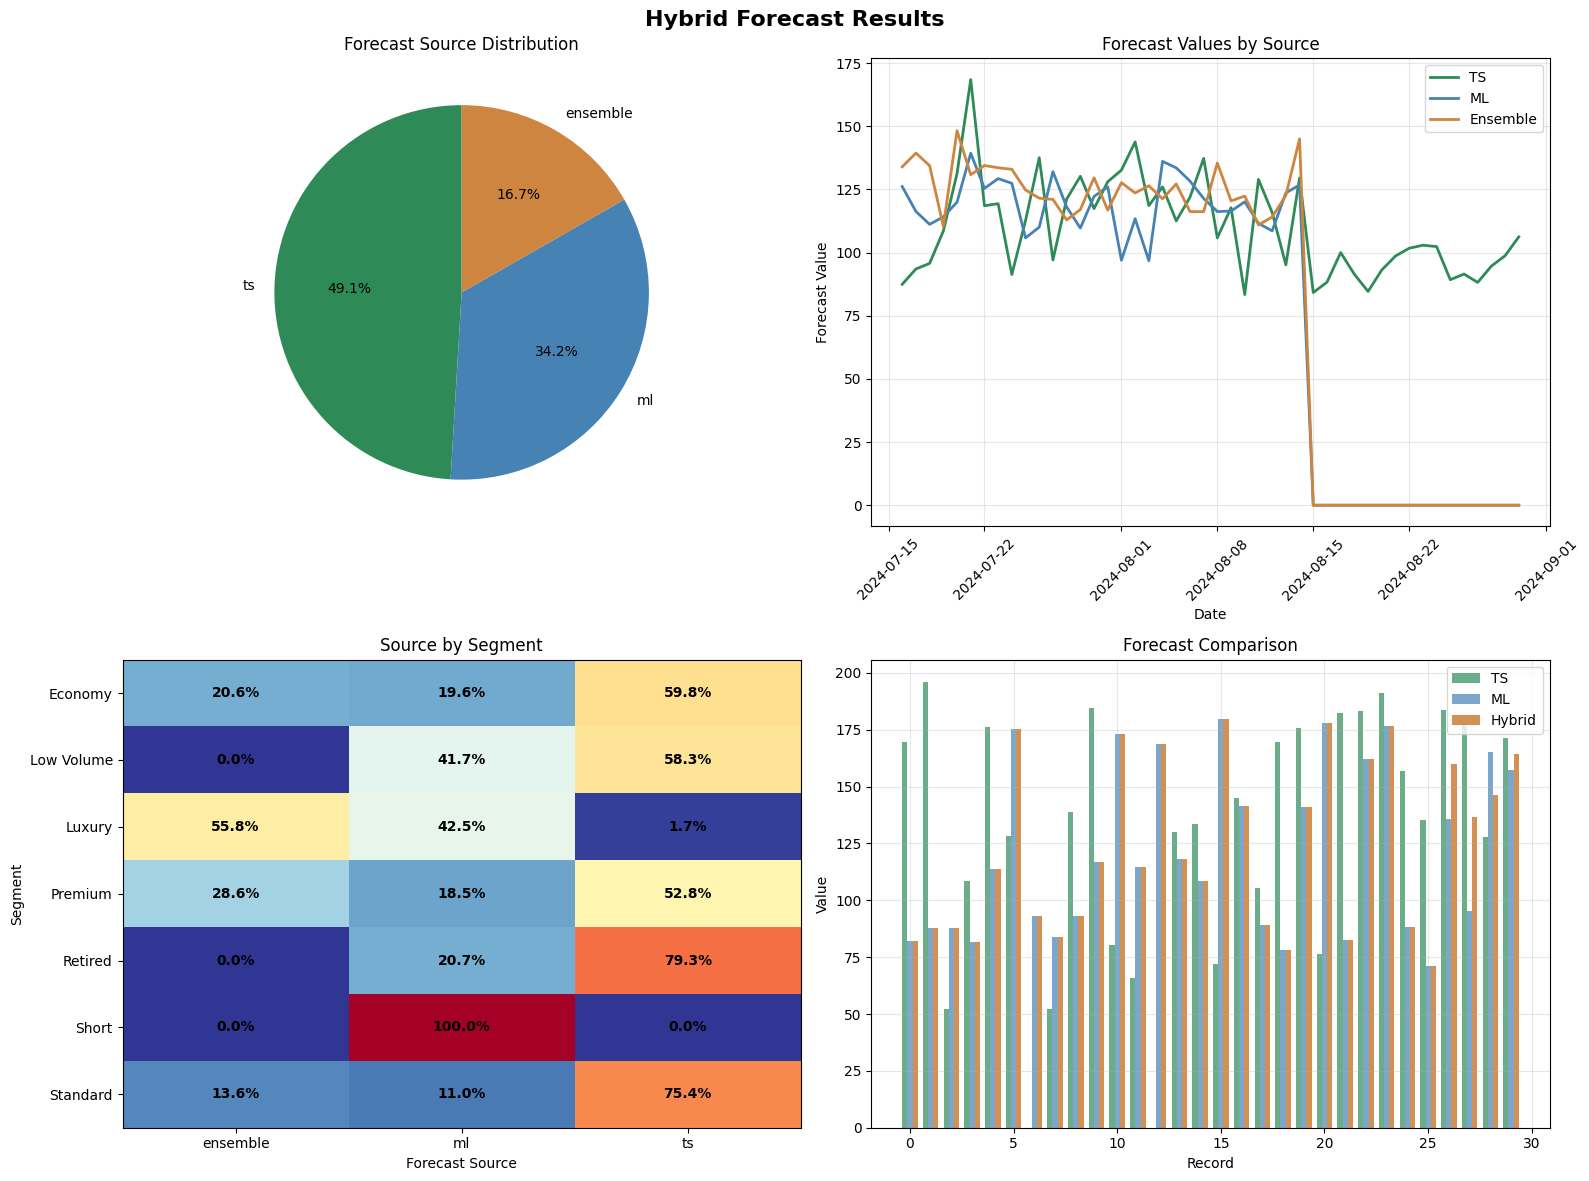

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hybrid Forecast Results', fontsize=16, fontweight='bold')

# Source distribution
ax1 = axes[0, 0]
source_counts = hybrid_forecast['FORECAST_SOURCE'].value_counts()
colors = ['#2E8B57', '#4682B4', '#CD853F']
ax1.pie(source_counts.values, labels=source_counts.index, 
       autopct='%1.1f%%', colors=colors[:len(source_counts)], startangle=90)
ax1.set_title('Forecast Source Distribution')

# Time series by source
ax2 = axes[0, 1]
time_series = hybrid_forecast.groupby(['PERIOD_DT', 'FORECAST_SOURCE'])['HYBRID_FORECAST_VALUE'].mean().unstack(fill_value=0)

if 'ts' in time_series.columns:
    ax2.plot(time_series.index, time_series['ts'], label='TS', color='#2E8B57', linewidth=2)
if 'ml' in time_series.columns:
    ax2.plot(time_series.index, time_series['ml'], label='ML', color='#4682B4', linewidth=2)
if 'ensemble' in time_series.columns:
    ax2.plot(time_series.index, time_series['ensemble'], label='Ensemble', color='#CD853F', linewidth=2)

ax2.set_title('Forecast Values by Source')
ax2.set_xlabel('Date')
ax2.set_ylabel('Forecast Value')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Business rules heatmap
ax3 = axes[1, 0]
segment_source_pct = pd.crosstab(hybrid_forecast['SEGMENT_NAME'], 
                                hybrid_forecast['FORECAST_SOURCE'], 
                                normalize='index') * 100

im = ax3.imshow(segment_source_pct.values, cmap='RdYlBu_r', aspect='auto')
ax3.set_xticks(range(len(segment_source_pct.columns)))
ax3.set_yticks(range(len(segment_source_pct.index)))
ax3.set_xticklabels(segment_source_pct.columns)
ax3.set_yticklabels(segment_source_pct.index)

for i in range(len(segment_source_pct.index)):
    for j in range(len(segment_source_pct.columns)):
        ax3.text(j, i, f'{segment_source_pct.iloc[i, j]:.1f}%',
                ha="center", va="center", color="black", fontweight='bold')

ax3.set_title('Source by Segment')
ax3.set_xlabel('Forecast Source')
ax3.set_ylabel('Segment')

# Value comparison
ax4 = axes[1, 1]
sample_data = hybrid_forecast.dropna(subset=['TS_FORECAST_VALUE', 'ML_FORECAST_VALUE']).head(30)

if len(sample_data) > 0:
    x_pos = np.arange(len(sample_data))
    width = 0.25
    
    ax4.bar(x_pos - width, sample_data['TS_FORECAST_VALUE'], width, 
           label='TS', color='#2E8B57', alpha=0.7)
    ax4.bar(x_pos, sample_data['ML_FORECAST_VALUE'], width, 
           label='ML', color='#4682B4', alpha=0.7)
    ax4.bar(x_pos + width, sample_data['HYBRID_FORECAST_VALUE'], width, 
           label='Hybrid', color='#CD853F', alpha=0.9)
    
    ax4.set_title('Forecast Comparison')
    ax4.set_xlabel('Record')
    ax4.set_ylabel('Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
print("Validation Summary:")
print(f"Total records: {len(hybrid_forecast)}")

source_dist = hybrid_forecast['FORECAST_SOURCE'].value_counts()
print(f"Source distribution: {dict(source_dist)}")

ml_priority_mask = (
    ((hybrid_forecast['DEMAND_TYPE'].str.lower() == 'promo') & 
     (hybrid_forecast['SEGMENT_NAME'].str.lower() != 'retired')) |
    (hybrid_forecast['SEGMENT_NAME'].str.lower() == 'short') |
    (hybrid_forecast['ASSORTMENT_TYPE'].str.lower() == 'new')
)
ml_correct = (hybrid_forecast[ml_priority_mask]['FORECAST_SOURCE'] == 'ml').sum()
print(f"ML rule accuracy: {ml_correct}/{ml_priority_mask.sum()}")

ts_priority_mask = (
    (hybrid_forecast['SEGMENT_NAME'].str.lower() == 'retired') |
    (hybrid_forecast['SEGMENT_NAME'].str.lower() == 'low volume') |
    (hybrid_forecast['TS_FORECAST_VALUE'] <= IB_ZERO_DEMAND_THRESHOLD)
)
ts_correct = (hybrid_forecast[ts_priority_mask]['FORECAST_SOURCE'] == 'ts').sum()
print(f"TS rule accuracy: {ts_correct}/{ts_priority_mask.sum()}")


Validation Summary:
Total records: 1380
Source distribution: {'ts': np.int64(677), 'ml': np.int64(472), 'ensemble': np.int64(231)}
ML rule accuracy: 472/472
TS rule accuracy: 197/295
